### Building an image classification model using very little data  

Based on the tutorial by Francois Chollet @fchollet https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html and the workbook by Guillaume Dominici https://github.com/gggdominici/keras-workshop

This tutorial presents several ways to build an image classifier using keras from just a few hundred or thousand pictures from each class you want to be able to recognize.

We will go over the following options:  

- training a small network from scratch (as a baseline)  
- using the bottleneck features of a pre-trained network  
- fine-tuning the top layers of a pre-trained network  
  
This will lead us to cover the following Keras features:   
  
- fit_generator for training Keras a model using Python data generators  
- ImageDataGenerator for real-time data augmentation  
- layer freezing and model fine-tuning  
- ...and more.  


## Data

Data can be downloaded at:
https://www.kaggle.com/c/dogs-vs-cats/data  
All you need is the train set  
The recommended folder structure is:  

### Folder structure

```python
data/
    train/
        dogs/ ### 1024 pictures
            dog001.jpg
            dog002.jpg
            ...
        cats/ ### 1024 pictures
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/ ### 416 pictures
            dog001.jpg
            dog002.jpg
            ...
        cats/ ### 416 pictures
            cat001.jpg
            cat002.jpg
            ...
```
Note : for this example we only consider 2x1000 training images and 2x400 testing images among the 2x12500 available.

The github repo includes about 1500 images for this model. The original Kaggle dataset is much larger. The purpose of this demo is to show how you can build models with smaller size datasets. You should be able to improve this model by using more data.

### Data loading

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!nvidia-smi

Mon May 20 19:52:12 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    17W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11925368468887995304, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16238337610764221340
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16664474100595696373
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14800692839
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8255418864457878577
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [7]:
##Updated to Keras 2.0
import os
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras import applications
from keras.models import Model
from IPython.display import Image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


### Data Loading

In [0]:
img_width, img_height = 128, 128
batch_size = 50

In [0]:
train_array=np.load('/content/drive/My Drive/gpu/3direction_array_intrain.npy',allow_pickle=True)
inval_array=np.load('/content/drive/My Drive/gpu/3direction_array_inval.npy',allow_pickle=True)
val_array=np.load('/content/drive/My Drive/gpu/3direction_array_val.npy',allow_pickle=True)


In [0]:
train_array.shape

(35569, 3)

###train data processing**

In [0]:
train_data=np.array([i[2] for i in train_array])
train_label=np.array([i[1] for i in train_array])
train_id=np.array([i[0] for i in train_array])
train_data = train_data.reshape(-1, 128,128, 1)
train_data=train_data.astype('float32')
train_data = train_data / np.max(train_data)

In [0]:
train_id_unique=np.unique(train_id)
train_id_label=np.array(list(zip(train_id,train_label)))
train_unique_labels=[]
for i in range(len(train_id_unique)):
  ID=train_id_unique[i]
  index=(train_id_label[:,0]==ID)
  label=int(np.unique(train_id_label[index][:,1])[0])
  train_unique_labels.append(label)

###inval data processing**

In [0]:
inval_data=np.array([i[2] for i in inval_array])
inval_label=np.array([i[1] for i in inval_array])
inval_id=np.array([i[0] for i in inval_array])
inval_data = inval_data.reshape(-1, 128,128, 1)
inval_data=inval_data.astype('float32')
inval_data = inval_data / np.max(inval_data)

In [0]:
inval_id_unique=np.unique(inval_id)
inval_id_label=np.array(list(zip(inval_id,inval_label)))
inval_unique_labels=[]
for i in range(len(inval_id_unique)):
  ID=inval_id_unique[i]
  index=(inval_id_label[:,0]==ID)
  label=int(np.unique(inval_id_label[index][:,1])[0])
  inval_unique_labels.append(label)

## val data processing

In [0]:
val_data=np.array([i[2] for i in val_array])
val_label=np.array([i[1] for i in val_array])
val_id=np.array([i[0] for i in val_array])
val_data = val_data.reshape(-1, 128,128, 1)
val_data=val_data.astype('float32')
val_data = val_data / np.max(val_data)

In [0]:
val_id_unique=np.unique(val_id)
val_id_label=np.array(list(zip(val_id,val_label)))
val_unique_labels=[]
for i in range(len(val_id_unique)):
  ID=val_id_unique[i]
  index=(val_id_label[:,0]==ID)
  label=int(np.unique(val_id_label[index][:,1])[0])
  val_unique_labels.append(label)

In [0]:
from keras.utils import to_categorical
train_label1=to_categorical(train_label,2)
inval_label1=to_categorical(inval_label,2)
val_label1=to_categorical(val_label,2)

In [0]:
# for i in range(len(all_id_unique)):
#   ID=all_id_unique[i]
#   index=(id_prediction[:,0]==ID)
#   prediction=list(id_prediction[index][:,1])
#   if prediction.count('1')>=prediction.count('0'):
#     final_pre=1
#   else:
#     final_pre=0
#   unique_predictions.append(final_pre)
#   mix=[[ID],prediction]
#   combine_data.append(mix)

In [0]:
# test_id_label=np.array(list(zip(test_id,test_label)))
# test_id_unique=np.unique(test_id)
# test_unique_labels=[]
# for i in range(len(test_id_unique)):
#   ID=test_id_unique[i]
#   index=(test_id_label[:,0]==ID)
#   label=int(np.unique((test_id_label[index][:,1])))
#   print(ID)
# #   test_unique_labels.append(label)

### Imports

In [0]:
##preprocessing
# used to rescale the pixel values from [0, 255] to [0, 1] interval
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 8

# automagically retrieve images and their classes for train and validation sets
train_generator = datagen.flow_from_directory(
        train_data_dir,
        color_mode='grayscale',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        color_mode='grayscale',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

Found 5502 images belonging to 2 classes.
Found 1835 images belonging to 2 classes.


## Small Conv Net

### Model architecture definition

In [17]:
# a simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers.
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(img_width, img_height,1)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
from keras.layers.normalization import BatchNormalization
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(img_width, img_height,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

In [0]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(128,128,1)))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
  fro

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
activation_16 (Activation)   (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 61, 61, 32)        9248      
_________________________________________________________________
batch_normalization_3 (Batch (None, 61, 61, 32)        128       
_________________________________________________________________
activation_17 (Activation)   (None, 61, 61, 32)        0         
__________

In [0]:
model.layers[0].input

<tf.Tensor 'conv2d_1_input:0' shape=(?, 128, 128, 1) dtype=float32>

In [0]:
from keras import optimizers
sgd=optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

### Training

In [0]:
epochs = 300
batch_size=50
train_samples = 4924
validation_samples = 1231
stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=50,mode='min', verbose=1)

In [20]:
history=model.fit(train_data,train_label1,validation_data=(inval_data,inval_label1),callbacks=[stop],epochs=50,verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 35569 samples, validate on 7861 samples
Epoch 1/50
35569/35569 [==============================] - 35s 988us/step - loss: 0.6392 - acc: 0.6569 - val_loss: 0.6507 - val_acc: 0.6442
Epoch 2/50
35569/35569 [==============================] - 31s 883us/step - loss: 0.6233 - acc: 0.6611 - val_loss: 0.6500 - val_acc: 0.6432
Epoch 3/50
35569/35569 [==============================] - 31s 875us/step - loss: 0.5817 - acc: 0.6907 - val_loss: 0.6561 - val_acc: 0.6371
Epoch 4/50
35569/35569 [==============================] - 31s 885us/step - loss: 0.5208 - acc: 0.7395 - val_loss: 0.6450 - val_acc: 0.6270
Epoch 5/50
35569/35569 [==============================] - 31s 876us/step - loss: 0.4507 - acc: 0.7837 - val_loss: 0.6630 - val_acc: 0.6266
Epoch 6/50
35569/35569 [==============================] - 31s 876us/step - loss: 0.3908 - acc: 0.8177 - val_loss: 0.7045 - val_acc: 0.6124
Epoch 7/50
35569/35569 [==============================] - 31s 884us/s

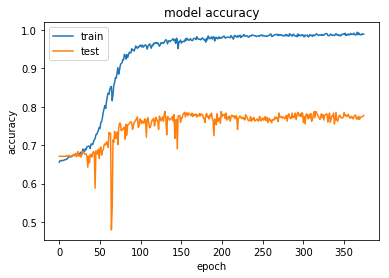

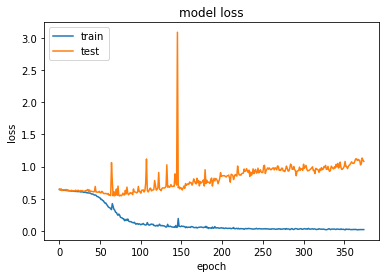

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [0]:
# model.fit_generator(
#         train_generator,
#         steps_per_epoch=train_samples // batch_size,
#         callbacks=[stop],
#         epochs=epochs,
#         validation_data=validation_generator,
#         validation_steps=validation_samples// batch_size,)
# #About 60 seconds an epoch when using CPU

In [0]:
model.save_weights('/content/drive/My Drive/gpu/top_model_weights.h5')

In [0]:
#model.save_weights('models_trained/basic_cnn_30_epochs.h5')
model.load_weights('models_trained/basic_cnn_30_epochs.h5')

If your model successfully runs at one epoch, go back and it for 30 epochs by changing nb_epoch above.  I was able to get to an val_acc of 0.71 at 30 epochs.
A copy of a pretrained network is available in the pretrained folder.

### Validating the Model's Performance

### Visualizing a Convolutional Neural Network

### Evaluating on validation set

In [0]:
# Using quiver
#!pip install quiver_engine

In [0]:
from keras.applications.vgg16 import VGG16
model_vgg = VGG16(weights='imagenet', include_top=False)

In [0]:
from quiver_engine import server
#server.launch(model_vgg,input_folder='./raj')

Computing loss and accuracy :

In [0]:
model.evaluate(train_data,train_label1)

4924/4924 [==============================] - 1s 204us/step


[0.21723145989733872, 0.9555239642082822]

In [0]:
model.evaluate(test_data,test_label1)

1231/1231 [==============================] - 0s 254us/step


[0.9565536082033023, 0.7912266451493208]

In [0]:
model.evaluate(validation_data,validation_label1)

1182/1182 [==============================] - 0s 200us/step


[2.3569854887205532, 0.6032148899160666]

In [0]:
test_prob=model.predict(test_data)

In [0]:
train_classes=model.predict_classes(train_data)

In [0]:
test_classes = model.predict_classes(test_data)

In [0]:
test_classes

array([0, 0, 1, ..., 0, 0, 1])

In [0]:
list(test_classes).count(0),list(test_classes).count(1)

(822, 371)

In [0]:
list(test_label).count(0),list(test_label).count(1)

(781, 412)

**validation performance check**

In [0]:
validation_prob=model.predict(validation_data)
validation_classes=model.predict_classes(validation_data)
validation_preds=np.argmax(validation_prob,axis=1)
validation_prob=validation_prob[:,1]
val_id_unique=np.unique(validation_id)
val_id_prediction=np.array(list(zip(validation_id,validation_preds)))
val_combine_data=[]
val_unique_predictions=[]
for i in range(len(val_id_unique)):
  ID=val_id_unique[i]
  index=(val_id_prediction[:,0]==ID)
  prediction=list(val_id_prediction[index][:,1])
  if prediction.count('1')>=prediction.count('0'):
    final_pre=1
  else:
    final_pre=0
  val_unique_predictions.append(final_pre)
  mix=[[ID],prediction]
  val_combine_data.append(mix)

In [0]:
val_id_label=np.array(list(zip(validation_id,validation_label)))
val_unique_labels=[]
for i in range(len(val_id_unique)):
  ID=val_id_unique[i]
  index=(val_id_label[:,0]==ID)
  label=int(np.unique(val_id_label[index][:,1])[0])
  val_unique_labels.append(label)

In [0]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(val_unique_labels,val_unique_predictions)
print('confusion matrix \n',cm)
total=sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
print('accuray ',accuracy)
sensitivity=cm[1,1]/(cm[1,1]+cm[1,0])
print('sensitivity ',sensitivity)
specificity=cm[0,0]/(cm[0,0]+cm[0,1])
print('specificity ',specificity)
ppv = cm[1,1]/(cm[1,1]+cm[0,1])
print('PPV  ', ppv)
npv = cm[0,0]/(cm[0,0]+cm[1,0])
print('NPV  ', npv)
PLR=sensitivity/(1-specificity)
print('Positive likelihood ratio ',PLR)
NLR=(1-sensitivity)/specificity
print('Negative likelihood ratio ',NLR)
DOR=PLR/NLR
print('Diagnostic odds ratio ',DOR)

confusion matrix 
 [[36  3]
 [23  6]]
accuray  0.6176470588235294
sensitivity  0.20689655172413793
specificity  0.9230769230769231
PPV   0.6666666666666666
NPV   0.6101694915254238
Positive likelihood ratio  2.689655172413795
Negative likelihood ratio  0.8591954022988506
Diagnostic odds ratio  3.1304347826086976


In [0]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(test_label, np.argmax(test_prob, axis=1))
auc_test = auc(fpr, tpr)
auc_test

NameError: ignored

In [0]:
import sklearn
cm=sklearn.metrics.confusion_matrix(train_label,train_classes)
print('confusion matrix \n',cm)
total=sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
print('accuray ',accuracy)
sensitivity=cm[1,1]/(cm[1,1]+cm[1,0])
print('sensitivity ',sensitivity)
specificity=cm[0,0]/(cm[0,0]+cm[0,1])
print('specificity ',specificity)
ppv = cm[1,1]/(cm[1,1]+cm[0,1])
print('PPV  ', ppv)
npv = cm[0,0]/(cm[0,0]+cm[1,0])
print('NPV  ', npv)
PLR=sensitivity/(1-specificity)
print('Positive likelihood ratio ',PLR)
NLR=(1-sensitivity)/specificity
print('Negative likelihood ratio ',NLR)
DOR=PLR/NLR
print('Diagnostic odds ratio ',DOR)

confusion matrix 
 [[2871   85]
 [ 129 1687]]
accuray  0.9551550712489523
sensitivity  0.9289647577092511
specificity  0.9712449255751014
PPV   0.9520316027088036
NPV   0.957
Positive likelihood ratio  32.30611557398285
Negative likelihood ratio  0.07313834072150946
Diagnostic odds ratio  441.71244870040994


In [0]:
import sklearn
cm=sklearn.metrics.confusion_matrix(test_label,test_classes)
print('confusion matrix \n',cm)
total=sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
print('accuray ',accuracy)
sensitivity=cm[1,1]/(cm[1,1]+cm[1,0])
print('sensitivity ',sensitivity)
specificity=cm[0,0]/(cm[0,0]+cm[0,1])
print('specificity ',specificity)
ppv = cm[1,1]/(cm[1,1]+cm[0,1])
print('PPV  ', ppv)
npv = cm[0,0]/(cm[0,0]+cm[1,0])
print('NPV  ', npv)
PLR=sensitivity/(1-specificity)
print('Positive likelihood ratio ',PLR)
NLR=(1-sensitivity)/specificity
print('Negative likelihood ratio ',NLR)
DOR=PLR/NLR
print('Diagnostic odds ratio ',DOR)


confusion matrix 
 [[656 125]
 [166 246]]
accuray  0.7560771165129925
sensitivity  0.5970873786407767
specificity  0.8399487836107554
PPV   0.6630727762803235
NPV   0.7980535279805353
Positive likelihood ratio  3.730601941747572
Negative likelihood ratio  0.47968713000236807
Diagnostic odds ratio  7.777156626506021


**combine patient slices prob**

In [0]:
all_prediction_prob=model.predict(all_data)

In [0]:
all_label

array([0, 0, 0, ..., 1, 1, 1])

In [0]:
all_id_unique=np.unique(all_id)

In [0]:
len(all_id_unique)

352

In [0]:
preds=np.argmax(all_prediction_prob,axis=1)
prob=all_prediction_prob[:,1]

In [0]:
id_prediction=np.array(list(zip(all_id,preds)))

In [0]:
combine_data=[]
unique_predictions=[]
for i in range(len(all_id_unique)):
  ID=all_id_unique[i]
  index=(id_prediction[:,0]==ID)
  prediction=list(id_prediction[index][:,1])
  if prediction.count('1')>=prediction.count('0'):
    final_pre=1
  else:
    final_pre=0
  unique_predictions.append(final_pre)
  mix=[[ID],prediction]
  combine_data.append(mix)

In [0]:
import sklearn
cm=sklearn.metrics.confusion_matrix(unique_labels,unique_predictions)
print('confusion matrix \n',cm)
total=sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
print('accuray ',accuracy)
sensitivity=cm[1,1]/(cm[1,1]+cm[1,0])
print('sensitivity ',sensitivity)
specificity=cm[0,0]/(cm[0,0]+cm[0,1])
print('specificity ',specificity)
ppv = cm[1,1]/(cm[1,1]+cm[0,1])
print('PPV  ', ppv)
npv = cm[0,0]/(cm[0,0]+cm[1,0])
print('NPV  ', npv)
PLR=sensitivity/(1-specificity)
print('Positive likelihood ratio ',PLR)
NLR=(1-sensitivity)/specificity
print('Negative likelihood ratio ',NLR)
DOR=PLR/NLR
print('Diagnostic odds ratio ',DOR)

ValueError: ignored

**evaluate on each patient**

In [0]:
for i in range()

'LUNG1-001'

In [0]:
# final_table=[]
# for i in range(len(all_id_unique)):
#   ID=combine_data[i][0]
#   pre=combine_data[i][1]
#   if pre.count('1')>=pre.count('0'):
#     final_pre=1
#   else:
#     final_pre=0
#   table=[[ID],final_pre]
#   final_table.append(table)

In [0]:
# final_decision=list([final_table[i][1] for i in range(len(all_id_unique))])

In [0]:
model.evaluate(all_data,to_categorical(all_label,2))

7337/7337 [==============================] - 2s 333us/step


[3.7329714384036086, 0.7636636227422113]

Evolution of accuracy on training (blue) and validation (green) sets for 1 to 32 epochs :

![Accuracy evolution](pictures/scores_no_dataaugmentation.png)

**After ~10 epochs the neural network reach ~70% accuracy. We can witness overfitting, no progress is made over validation set in the next epochs**

## Data augmentation for improving the model

By applying random transformation to our train set, we artificially enhance our dataset with new unseen images.  
This will hopefully reduce overfitting and allows better generalization capability for our network.

Example of data augmentation applied to a picture:
![Example of data augmentation applied to a picture](pictures/cat_data_augmentation.png)

In [0]:
train_datagen_augmented = ImageDataGenerator(
        rescale=1./255,        # normalize pixel values to [0,1]
        shear_range=0.2,       # randomly applies shearing transformation
        zoom_range=0.2,        # randomly applies shearing transformation
        horizontal_flip=True)  # randomly flip the images

# same code as before
train_generator_augmented = train_datagen_augmented.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 200 images belonging to 2 classes.


In [0]:
##Lets look at the training data
img = load_img('data/train/cats/cat.0.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  

i = 0
for batch in train_datagen_augmented.flow(x,batch_size=1,
                          save_to_dir='preview', save_prefix='aug2', save_format='jpg'):
    i += 1
    if i > 5:
        break  #

FileNotFoundError: [Errno 2] No such file or directory: 'data/train/cats/cat.0.jpg'

In [0]:
!ls preview

aug2_0_125.jpg	  train_10_2638.jpg  train_1_6767.jpg	train_4_3297.jpg
aug2_0_1805.jpg   train_10_3001.jpg  train_17_2432.jpg	train_4_3753.jpg
aug2_0_1983.jpg   train_11_4831.jpg  train_17_5031.jpg	train_5_2054.jpg
aug2_0_2253.jpg   train_11_6773.jpg  train_1_75.jpg	train_5_6591.jpg
aug2_0_3107.jpg   train_12_1168.jpg  train_18_8046.jpg	train_6_6153.jpg
aug2_0_4003.jpg   train_12_9061.jpg  train_18_8431.jpg	train_6_8550.jpg
aug2_0_6103.jpg   train_13_3936.jpg  train_19_6181.jpg	train_7_6307.jpg
aug2_0_6544.jpg   train_13_737.jpg   train_19_9408.jpg	train_7_8120.jpg
aug2_0_7307.jpg   train_14_3427.jpg  train_20_7450.jpg	train_8_2649.jpg
aug2_0_8106.jpg   train_14_7598.jpg  train_20_7602.jpg	train_8_3558.jpg
aug2_0_81.jpg	  train_15_3216.jpg  train_2_1654.jpg	train_9_3911.jpg
aug2_0_8474.jpg   train_15_5589.jpg  train_2_8433.jpg	train_9_5143.jpg
train_0_5372.jpg  train_16_172.jpg   train_3_2508.jpg
train_0_7289.jpg  train_16_3743.jpg  train_3_3853.jpg


In [0]:
#model.load_weights('models_trained/augmented_30_epochs.h5')

### Evaluating on validation set

Computing loss and accuracy :

In [0]:
model.evaluate_generator(validation_generator, validation_samples)

[0.57709803022086048, 0.76551231971153844]

Evolution of accuracy on training (blue) and validation (green) sets for 1 to 100 epochs :

![Accuracy evolution](pictures/scores_with_dataaugmentation.png)

**Thanks to data-augmentation, the accuracy on the validation set improved to ~80%**

## Using a pre-trained model

The process of training a convolutionnal neural network can be very time-consuming and require a lot of datas.  

We can go beyond the previous models in terms of performance and efficiency by using a general-purpose, pre-trained image classifier.  This example uses VGG16, a model trained on the ImageNet dataset - which contains millions of images classified in 1000 categories. 

On top of it, we add a small multi-layer perceptron and we train it on our dataset.

### VGG16 + small MLP
![VGG16 + Dense layers Schema](pictures/vgg16_original.png)

#### VGG16 model is available in Keras

In [0]:
from keras.applications import ResNet50

In [0]:
model_pretrain = applications.resnet.ResNet50(input_shape=(128,128,3),include_top=False, weights='imagenet')
epochs = 300
train_samples = len(train_id)
validation_samples = len(inval_id)

AttributeError: ignored

In [0]:
batch_size

NameError: ignored

### Using the VGG16 model to process samples

In [0]:
train_3chanel=np.squeeze(np.stack((train_data,) * 3, -1))


In [0]:
test_3chanel=np.squeeze(np.stack((inval_data,) * 3, -1))

In [0]:
model_pretrain.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [0]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 11.8 GB  | Proc size: 120.0 MB
GPU RAM Free: 8938MB | Used: 2503MB | Util  22% | Total 11441MB


This is a long process, so we save the output of the VGG16 once and for all.  

In [0]:
bottleneck_features_train = model_pretrain.predict(train_3chanel,verbose=1)
print('done for train')
np.save(open('/content/drive/My Drive/gpu/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

4809/4809 [==============================] - 8s 2ms/step
done for train


In [0]:
bottleneck_features_train.shape

(4809, 4, 4, 512)

In [0]:
bottleneck_features_train1.shape

(2809, 4, 4, 512)

In [0]:
bottleneck_features_validation = model_pretrain.predict(test_3chanel,verbose=1)
print('done for test')
np.save(open('/content/drive/My Drive/gpu/bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

1346/1346 [==============================] - 3s 2ms/step
done for test


Now we can load it...

In [0]:
train_feature = np.load(open('/content/drive/My Drive/gpu/bottleneck_features_train.npy', 'rb'))
train_labels = train_label

validation_feature = np.load(open('/content/drive/My Drive/gpu/bottleneck_features_validation.npy', 'rb'))
validation_labels = inval_label




(2809, 4, 4, 512)

And define and train the custom fully connected neural network :

In [0]:
model_top = Sequential()
model_top.add(Flatten(input_shape=train_feature.shape[1:]))
model_top.add(Dense(512, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(1, activation='sigmoid'))

model_top.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])


In [0]:
model_top.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 4,326,401
Trainable params: 4,326,401
Non-trainable params: 0
_________________________________________________________________


In [0]:
inval_label.count(0)

AttributeError: ignored

In [0]:
top_history=model_top.fit(train_feature, train_labels,
        epochs=epochs, 
        batch_size=batch_size,
        validation_data=(validation_feature, validation_labels))


Train on 4809 samples, validate on 1346 samples
Epoch 1/300
4809/4809 [==============================] - 1s 250us/step - loss: 0.8788 - acc: 0.6082 - val_loss: 0.6506 - val_acc: 0.6538
Epoch 2/300
4809/4809 [==============================] - 1s 143us/step - loss: 0.6447 - acc: 0.6475 - val_loss: 0.7284 - val_acc: 0.6538
Epoch 3/300
4809/4809 [==============================] - 1s 137us/step - loss: 0.6173 - acc: 0.6611 - val_loss: 0.6410 - val_acc: 0.6501
Epoch 4/300
4809/4809 [==============================] - 1s 135us/step - loss: 0.5918 - acc: 0.6619 - val_loss: 0.8861 - val_acc: 0.6538
Epoch 5/300
4809/4809 [==============================] - 1s 139us/step - loss: 0.5752 - acc: 0.6764 - val_loss: 0.6818 - val_acc: 0.6152
Epoch 6/300
4809/4809 [==============================] - 1s 135us/step - loss: 0.5632 - acc: 0.6812 - val_loss: 0.7216 - val_acc: 0.6166
Epoch 7/300
4809/4809 [==============================] - 1s 134us/step - loss: 0.5551 - acc: 0.6873 - val_loss: 0.7729 - val_acc: 

The training process of this small neural network is very fast : ~2s per epoch

In [0]:
model_top.save_weights('/content/drive/My Drive/gpu/bottleneck_300_epochs.h5')

### Bottleneck model evaluation

In [0]:
#model_top.load_weights('models/bottleneck_30_epochs.h5)

Loss and accuracy :

In [0]:
model_top.evaluate(validation_data, validation_labels)

1346/1346 [==============================] - 0s 79us/step


[3.592292955892339, 0.6181277860326895]

Evolution of accuracy on training (blue) and validation (green) sets for 1 to 32 epochs :

![Accuracy evolution](pictures/scores_with_bottleneck.png)

**We reached a 90% accuracy on the validation after ~1m of training (~20 epochs) and 8% of the samples originally available on the Kaggle competition !**

## Fine-tuning the top layers of a a pre-trained network

Start by instantiating the VGG base and loading its weights.

In [0]:
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
##Updated to Keras 2.0
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras import applications
from keras.models import Model
from IPython.display import Image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [0]:
train_data_dir ='/Users/zhangchong/deep_learning/Open_I_abd_vs_CXRs/TRAIN'
validation_data_dir ='/Users/zhangchong/deep_learning/Open_I_abd_vs_CXRs/VAL'
train_samples=65
validation_samples=10
img_width, img_height = 150, 150

In [0]:
model_vgg=applications.VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

Build a classifier model to put on top of the convolutional model. For the fine tuning, we start with a fully trained-classifer. We will use the weights from the earlier model. And then we will add this model on top of the convolutional base.

In [0]:
model_top=Sequential()
model_top.add(Flatten(input_shape=model_vgg.output_shape[1:]))
model_top.add(Dense(512,activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(256,activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(1,activation='sigmoid'))
model_top.load_weights('/content/drive/My Drive/gpu/bottleneck_300_epochs.h5')
#model_vgg.add(top_model)
model = Model(inputs = model_vgg.input, outputs = model_top(model_vgg.output))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

For fine turning, we only want to train a few layers.  This line will set the first 25 layers (up to the conv block) to non-trainable.

In [0]:
for layer in model_vgg.layers[:15]:
    layer.trainable = False
# for layer in model_v3.layers:
#     layer.trainable = False

In [0]:
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
# model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [0]:
train_label.shape

(4809,)

In [0]:
batch_size=5
model_histoty=model.fit(train_3chanel,train_label,validation_data=(test_3chanel,inval_label),verbose=1,epochs=300)

Train on 4809 samples, validate on 1346 samples
Epoch 1/300
4809/4809 [==============================] - 13s 3ms/step - loss: 0.7887 - acc: 0.4151 - val_loss: 0.6498 - val_acc: 0.6538
Epoch 2/300
4809/4809 [==============================] - 13s 3ms/step - loss: 0.6947 - acc: 0.5725 - val_loss: 0.6484 - val_acc: 0.6538
Epoch 3/300
4809/4809 [==============================] - 13s 3ms/step - loss: 0.6830 - acc: 0.5953 - val_loss: 0.6469 - val_acc: 0.6538
Epoch 4/300
4809/4809 [==============================] - 12s 3ms/step - loss: 0.6819 - acc: 0.5904 - val_loss: 0.6456 - val_acc: 0.6538
Epoch 5/300
4809/4809 [==============================] - 12s 3ms/step - loss: 0.6779 - acc: 0.6014 - val_loss: 0.6479 - val_acc: 0.6538
Epoch 6/300
4809/4809 [==============================] - 12s 3ms/step - loss: 0.6744 - acc: 0.6045 - val_loss: 0.6455 - val_acc: 0.6538
Epoch 7/300
4809/4809 [==============================] - 12s 3ms/step - loss: 0.6721 - acc: 0.6003 - val_loss: 0.6445 - val_acc: 0.6538


In [0]:
batch_size=5
# prepare data augmentation configuration  . . . do we need this?
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

Found 65 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [0]:
# fine-tune the model
model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size)

Epoch 1/15
13/13 [==============================] - 15s 1s/step - loss: 0.6780 - acc: 0.6462 - val_loss: 0.9857 - val_acc: 0.5000
Epoch 2/15
13/13 [==============================] - 3s 219ms/step - loss: 0.5827 - acc: 0.7077 - val_loss: 0.8727 - val_acc: 0.5000
Epoch 3/15
13/13 [==============================] - 3s 220ms/step - loss: 0.5248 - acc: 0.7538 - val_loss: 1.0671 - val_acc: 0.5000
Epoch 4/15
13/13 [==============================] - 3s 211ms/step - loss: 0.4175 - acc: 0.8615 - val_loss: 0.7034 - val_acc: 0.6000
Epoch 5/15
13/13 [==============================] - 3s 212ms/step - loss: 0.4298 - acc: 0.8462 - val_loss: 0.8096 - val_acc: 0.5000
Epoch 6/15
13/13 [==============================] - 3s 213ms/step - loss: 0.4825 - acc: 0.8000 - val_loss: 0.4993 - val_acc: 0.7000
Epoch 7/15
13/13 [==============================] - 3s 212ms/step - loss: 0.4284 - acc: 0.8615 - val_loss: 0.7543 - val_acc: 0.6000
Epoch 8/15
13/13 [==============================] - 3s 212ms/step - loss: 0.41

In [0]:
for i, layer in enumerate(model_v3.layers):
    print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [0]:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

In [0]:
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
model.fit_generator(train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size)

Epoch 1/15
13/13 [==============================] - 20s 2s/step - loss: 0.3586 - acc: 0.8462 - val_loss: 0.3201 - val_acc: 0.9000
Epoch 2/15
13/13 [==============================] - 4s 296ms/step - loss: 0.2870 - acc: 0.8769 - val_loss: 0.2570 - val_acc: 0.9000
Epoch 3/15
13/13 [==============================] - 4s 295ms/step - loss: 0.2343 - acc: 0.9538 - val_loss: 0.4785 - val_acc: 0.7000
Epoch 4/15
13/13 [==============================] - 4s 295ms/step - loss: 0.1493 - acc: 1.0000 - val_loss: 0.3594 - val_acc: 0.8000
Epoch 5/15
13/13 [==============================] - 4s 303ms/step - loss: 0.3103 - acc: 0.9077 - val_loss: 0.4878 - val_acc: 0.7000
Epoch 6/15
13/13 [==============================] - 4s 308ms/step - loss: 0.1814 - acc: 0.9538 - val_loss: 0.2861 - val_acc: 0.9000
Epoch 7/15
13/13 [==============================] - 4s 313ms/step - loss: 0.2428 - acc: 0.9077 - val_loss: 0.3010 - val_acc: 0.8000
Epoch 8/15
13/13 [==============================] - 4s 328ms/step - loss: 0.35

In [0]:
model.save_weights('models/finetuning_30epochs_vgg.h5')

In [0]:
model.load_weights('models/finetuning_30epochs_vgg.h5')

### Evaluating on validation set

Computing loss and accuracy :

In [0]:
model.evaluate_generator(validation_generator, validation_samples)

[0.33350689638357905, 0.93280498798076927]